In [1]:
import pandas as pd
import numpy as np
import sqlite3
import math

from numpy import transpose
from numpy.linalg import inv,pinv, det
from scipy.stats import norm
from scipy.special import expit as logistic
from sklearn.linear_model import LogisticRegression as LR
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from itertools import accumulate

engine = sqlite3.connect('yahoo')
np.set_printoptions(precision=3)
click_cols = ['time', 'user_1', 'user_2', 'user_3', 'user_4', 'user_5', 'user_6', 'displayed', 'clicked']

In [173]:
articles_df = pd.read_sql_query('SELECT * FROM articles',con=engine).set_index('index')
# Positive examples are very sparse in the click logs data.
# This presents a significant problem when trying to train our models.
# As such, we necessarily select a sufficient number of logs with
# positive and negative results. (An argument can be made towards the
# correctness of this approach by recognizing that a logged event is
# only included in the learning algorithm's history if it would have
# picked the corresponding arm to begin with.)
clicks_df_pos = pd.read_sql_query('''
    SELECT * FROM clicks WHERE (ABS(CAST((RANDOM()) as int)) % 100) < 100 AND length(article_pool) < 210 AND clicked = 1
''', con=engine)
clicks_df_neg = pd.read_sql_query('''
    SELECT * FROM clicks WHERE (ABS(CAST((RANDOM()) as int)) % 100) < 4 AND length(article_pool) < 210 AND clicked = 0
''', con=engine)

print('Selected {0} positive and {1} negative examples.'.format(clicks_df_pos.shape[0], clicks_df_neg.shape[0]))

clicks_df = pd.concat([clicks_df_pos, clicks_df_neg])
clicks_df[click_cols] = clicks_df[click_cols].apply(pd.to_numeric, ) # Temporary workaround, this should be done before sql
clicks_df['article_pool'] = clicks_df['article_pool'].apply(lambda x : eval(x))
clicks_df = clicks_df.sample(frac=1).reset_index()

# Joseph et. al use a learning model that assumes k-groups, each of which supplies an arm in each round.
# The original Yahoo! dataset does not comply with this assumption, as each of the 20 articles suggested
# are not necessarily from any such groups, nor is it a reasonable assumption that there are 20
# distinct quality functions corresponding to the indices of the pool.
# Instead, in a simplification, we perform clustering on all of the articles to assemble a smaller set of 
# `num_clusters` groups. Then, in each round, we instead pick a single representative article group for
# the user. 
num_clusters = 3
article_km = KMeans(n_clusters=num_clusters)
predictions = article_km.fit_predict(articles_df.dropna().as_matrix())
article_clusters = dict(zip(list(articles_df.dropna().index), predictions))
clicks_df['reduced'] = clicks_df['article_pool'].apply(lambda x : list(set([article_clusters[y] for y in x])))
clicks_df['displayed_reduced'] = clicks_df['displayed'].apply(lambda x : article_clusters[str(x)])

user_feat_mat = clicks_df.as_matrix(['user_1', 'user_2', 'user_3', 'user_4', 'user_5', 'user_6'])
clicked_mat = clicks_df.as_matrix(['displayed_reduced', 'clicked'])

Selected 60411 positive and 57924 negative examples.


In [3]:
def eta(T):
    """ 
    Generates the cutoff probabilities for exploration rounds in interval chaining. 
    
    :param T: the total number of iterations
    """
    return np.array([pow(t, -1/3) for t in range(1,T+1)])

In [4]:
def select_logged_event(t, k, d):
    """
    Select the t'th record from the event log.
    
    :param t: the timestep
    :param k: the number of arms
    :param d: the number of features
    :return:  a tuple containing a (k x 1 x d) log vector, the id of the article displayed,
              whether the article was clicked, and the article pool index corresponding
              to the article
    """
    # Extract all article vectors for first log item.
    _article_pool = clicks_df.ix[t]['reduced']
    _article_vecs = np.array([article_km.cluster_centers_[x] if x in _article_pool else np.zeros(6) for x in range(k)])
    # For each of the article row vectors, add a copy of the user features.
    logged = np.append(_article_vecs, values=np.tile(user_feat_mat[t], (len(_article_vecs), 1)), axis=1)
#     rewards = np.array(list(map(lambda x : 1 if int(x) == disp_mat[t] else 0, _article_pool)))
#     return np.vstack([X, logged.reshape((1, k, d))*1000]), np.append(Y, clicked_mat[t])
    disp_index = _article_pool.index(clicked_mat[t,0])
    
#     return logged.reshape((k, 1, d)), clicked_mat[t], disp_index
    return logged.reshape((k, 1, d)), clicked_mat[t, 0], clicked_mat[t, 1], disp_index

In [5]:
def logit_intervals(X, Y, k, _delta, T, article_pool):
    intervals = []
    for i in article_pool:
        t = len(X[i]) - 1
        model = LR() 
        if len(set(Y[i][:t])) < 2: 
            continue
        else:
            _Xti = X[i][:t]
            _XtiT = transpose(_Xti)
            _XTX = pinv(_XtiT.dot(_Xti))
            _Yti = Y[i][:t]
            _xti = X[i][t]
            model.fit(_Xti, _Yti)
            Bh_t_i = model.coef_
            yh_t_i = Bh_t_i.dot(_xti)[0]
            _s2 = np.var(_Yti)
            w_t_i = norm.ppf(1 - _delta/(2*T*k), loc=0, 
                         scale=np.sqrt(_s2 * _xti.dot(_XTX).dot(transpose(_xti))))
            if not math.isnan(w_t_i):
                intervals.append([logistic(yh_t_i - w_t_i), logistic(yh_t_i + w_t_i)])
            
    return intervals

In [17]:
# def ols_intervals(X, Y, k, _delta, T):
#     intervals = []
#     for i in range(k):
#         t = len(X[i])-1
#         if t <= 0:
#             continue
#         # Compute beta hat.
#         _Xti = X[i][:t]
#         _XtiT = transpose(_Xti)
#         _XTX = pinv(_XtiT.dot(_Xti))
#         _Yti = Y[i][:t]
#         Bh_t_i = _XTX.dot(_XtiT).dot(_Yti)  # Compute OLS estimators.
# #         from IPython.core.debugger import Tracer; Tracer()() 
#         yh_t_i = X[i][t].dot(Bh_t_i)
#         _s2 = np.var(Y[i][:t-1])
#         # Compute the confidence interval width using the inverse CDF.
#         w_t_i = norm.ppf(1 - _delta/(2*T*k), loc=0, 
#                          scale=np.sqrt(_s2 * X[i][t].dot(_XTX).dot(transpose(X[i][t]))))
#         if not math.isnan(w_t_i):
#             intervals.append([yh_t_i - w_t_i, yh_t_i + w_t_i])
#     return intervals

In [125]:
def compute_chain(i_st, intervals):
    # Sort intervals by decreasing order.
    chain = [i_st]
#     print(intervals[:,1])
    ordering = np.argsort(intervals[:,1])[::-1]
    intervals = intervals[ordering,:]
    
    lowest_in_chain = intervals[0][0]
    for i in range(1, len(intervals)):
        if intervals[i][1] >= lowest_in_chain:
            chain.append(i)
            lowest_in_chain = min(lowest_in_chain, intervals[i][0])
        else:
            return chain
    return chain

In [123]:
def pick_interval_chain(intervals, _article_pool):
    if not intervals or len(intervals) == 0:
        return np.random.choice(_article_pool)
    i_st = np.argmax(np.array(intervals)[:,1])
    chain = compute_chain(i_st, np.array(intervals))
#     print('Computed chain: {0}'.format(chain))
    return np.random.choice(chain)

In [113]:
def pick_top(intervals, _article_pool):
    return np.argmax(np.array(intervals)[:,1]) if len(intervals) > 0 else np.random.choice(_article_pool)

In [118]:
def bandits_yahoo(T, pick_fn):
    """
    Simulates T rounds of LRTopInterval for k using the evaluation framework
    described in https://arxiv.org/pdf/1003.5956.pdf.
    
    Evaluation Protocol
    ===================
    Let σ be an input stream of logged events to be used for the simulation,
    where an event consists of a tuple consisting of the user vector, 
    20 article vectors (context vectors), the displayed vector (selected arm), 
    and the result (observed reward).
    Step through each element s sampled from the stream.
    Let t denote the current time-step in the algorithm and h_{t-1} prior history.
    If given h_{t-1} and the current context, the algorithm picks the same vector
    as the selected arm - retain the event and add it to the history. Otherwise,
    keep processing items.
    
    :param T: the number of iterations to attempt.
    """
    k = num_clusters
    d = 12
    X = [np.empty((0, 12)) for i in range(k)]  # For each arm store a t' x d nd-array.
    Y = [np.empty((0,1)) for i in range(k)]
    _delta = 0.1
    _eta = eta(T)                               # exploration cutoff probabilities
    cursor = 0
    performance = []
    for t in range(T):
        if cursor >= len(clicks_df):
            break
        if t % 1000 == 0:
            print('Iteration {0}/{1}. Cursor: {2}'.format(t, T, cursor))
        if t < k:
            print('Seeding data for arm {0}'.format(t))
            # Pull each arm once to start.
            while cursor < len(clicks_df)-1:
                logged, _, disp_clicked, disp_index = select_logged_event(cursor, k, d)
                cursor += 1
                # Terminate this loop if we've found the arm we want
                if disp_index == t:
                    X[disp_index] = np.vstack([X[disp_index], logged[disp_index]])
                    Y[disp_index] = np.append(Y[disp_index], disp_clicked)
                    break
        elif t < d or np.random.rand() <= _eta[t]:
            # Play uniformly at random from [1, k].
            logged, _, disp_clicked, disp_index = select_logged_event(cursor, k, d)
            X[disp_index] = np.vstack([X[disp_index], logged[disp_index]])
            Y[disp_index] = np.append(Y[disp_index], disp_clicked)
            cursor += 1
#             print('Iteration [{0} / {1}]'.format(t, T))
        else:
            # Keep looping through the logs until the arm we pick matches with the one in the log.
            # This way, we can evaluate our success with the known result.
            while cursor < len(clicks_df)-1:
                # 1. Compute input vector for the next item in the stream and the corresponding reward.
                logged, _, disp_clicked, disp_index = select_logged_event(cursor, k, d)
                Xp = [np.vstack([X[i], logged[i]]) for i in range(k)]
                # 2. For each of the available arms, compute the confidence intervals.
                _article_pool = clicks_df.ix[cursor]['reduced']
                intervals = logit_intervals(Xp, Y, k, _delta, T, _article_pool)
                # Pick the agent with the largest upper bound.
                pick = pick_fn(intervals, _article_pool)
#                 print('Intervals: {0}'.format(intervals))
                if clicks_df.ix[cursor]['displayed_reduced'] == int(_article_pool[pick]):
                    X[disp_index] = np.vstack([X[disp_index], logged[disp_index]])
                    Y[disp_index] = np.append(Y[disp_index], disp_clicked)
#                     print('Iteration [{0} / {1}], matched with stream! {2}'.format(t, T, disp_clicked))
                    performance.append(disp_clicked)
                    cursor += 1
                    break
                cursor += 1
    
    # Compute sum of best picks over each iteration.
    print('Best: {0}'.format(t))
    print('Performance: {0}'.format(sum(performance)))
    return performance

In [119]:
def top_interval_yahoo(T):
    return bandits_yahoo(T, pick_top)

def interval_chaining_yahoo(T):
    return bandits_yahoo(T, pick_interval_chain)

In [174]:
performance_run = top_interval_yahoo(20000)

Iteration 0/20000. Cursor: 0
Seeding data for arm 0
Seeding data for arm 1
Seeding data for arm 2
Iteration 1000/20000. Cursor: 3715
Iteration 2000/20000. Cursor: 5994
Iteration 3000/20000. Cursor: 8235
Iteration 4000/20000. Cursor: 10287
Iteration 5000/20000. Cursor: 12157
Iteration 6000/20000. Cursor: 13826
Iteration 7000/20000. Cursor: 16341
Iteration 8000/20000. Cursor: 20121
Iteration 9000/20000. Cursor: 24010
Iteration 10000/20000. Cursor: 27330
Iteration 11000/20000. Cursor: 30459
Iteration 12000/20000. Cursor: 33096
Iteration 13000/20000. Cursor: 35574
Iteration 14000/20000. Cursor: 38274
Iteration 15000/20000. Cursor: 40911
Iteration 16000/20000. Cursor: 43510
Iteration 17000/20000. Cursor: 46156
Iteration 18000/20000. Cursor: 48564
Iteration 19000/20000. Cursor: 51101
Best: 19999
Performance: 10091


In [176]:
performance_run_2 = interval_chaining_yahoo(50000)

Iteration 0/50000. Cursor: 0
Seeding data for arm 0
Seeding data for arm 1
Seeding data for arm 2
Iteration 1000/50000. Cursor: 9098
Iteration 2000/50000. Cursor: 15128
Iteration 3000/50000. Cursor: 20066
Iteration 4000/50000. Cursor: 23734
Iteration 5000/50000. Cursor: 26806
Iteration 6000/50000. Cursor: 29558
Iteration 7000/50000. Cursor: 32180
Iteration 8000/50000. Cursor: 34920
Iteration 9000/50000. Cursor: 37668
Iteration 10000/50000. Cursor: 40574
Iteration 11000/50000. Cursor: 43377
Iteration 12000/50000. Cursor: 46296
Iteration 13000/50000. Cursor: 49089
Iteration 14000/50000. Cursor: 51862
Iteration 15000/50000. Cursor: 54615
Iteration 16000/50000. Cursor: 57389
Iteration 17000/50000. Cursor: 60204
Iteration 18000/50000. Cursor: 63089
Iteration 19000/50000. Cursor: 65979
Iteration 20000/50000. Cursor: 68840
Iteration 21000/50000. Cursor: 71658
Iteration 22000/50000. Cursor: 74627
Iteration 23000/50000. Cursor: 77290
Iteration 24000/50000. Cursor: 80061
Iteration 25000/50000. C

In [168]:
def plot_performance(performance_run, titles):
    plt.figure(figsize=(20, 8))
    
    cum_performance = np.array(list(accumulate(performance_run))) 
    cum_best = np.arange(1, len(cum_performance)+1)
    cum_regret = np.subtract(cum_best, cum_performance)
    plt.subplot(121)
    plt.plot(cum_best, cum_performance, c='teal')
    plt.plot(cum_best, cum_best, c='orange')
    plt.plot(cum_best, cum_regret, c='green')
    plt.xlabel('# Iterations')
    plt.ylabel('Cumulative # Successes')
    best_leg = mlines.Line2D([], [], color='orange', marker='_', markersize=11, label='Best', linestyle='')
    perf_leg = mlines.Line2D([], [], color='teal', marker='_', markersize=11, label='Performance', linestyle='')
    regret_leg = mlines.Line2D([], [], color='green', marker='_', markersize=11, label='Regret', linestyle='')
    plt.legend(handles=[best_leg, perf_leg, regret_leg])
    plt.title(titles[0])
    
    cum_success_rate = np.array([(y)/x for x,y in enumerate(cum_performance, start=1)])
    plt.subplot(122)
    plt.plot(cum_best, cum_success_rate, c='teal')
    plt.plot(cum_best, [1/num_clusters] * len(cum_performance), c='orange')
    plt.xlabel('# Iterations')
    plt.ylabel('Fraction Correct')
    perf_leg = mlines.Line2D([], [], color='teal', marker='_', markersize=11, label='Performance', linestyle='')
    baseline_leg = mlines.Line2D([], [], color='orange', marker='_', markersize=11, label='Baseline', linestyle='')
    plt.legend(handles=[perf_leg, baseline_leg])
    plt.title(titles[1])
    plt.show()
    

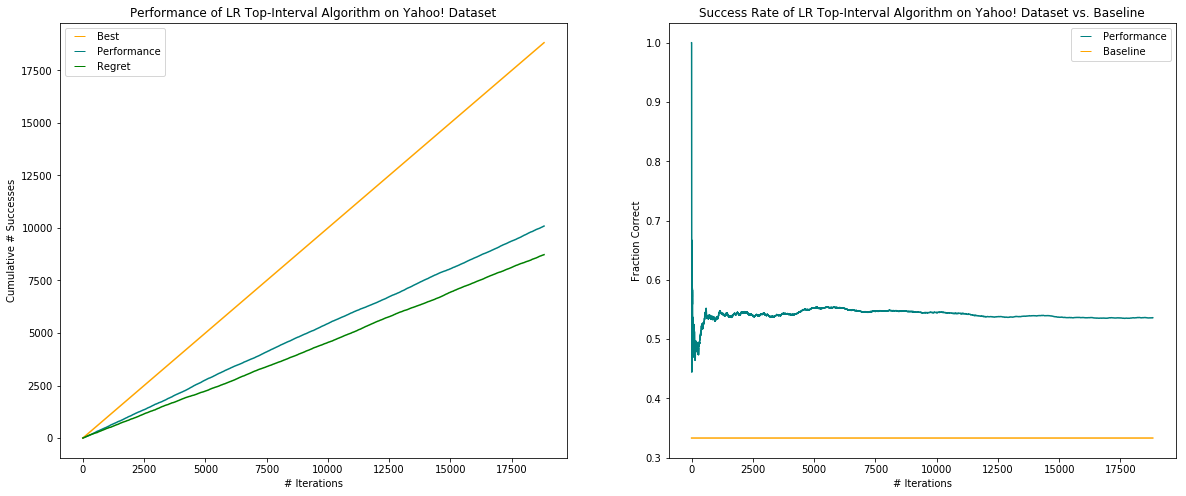

In [175]:
plot_performance(performance_run, titles=[
    'Performance of LR Top-Interval Algorithm on Yahoo! Dataset',
    'Success Rate of LR Top-Interval Algorithm on Yahoo! Dataset vs. Baseline'
])

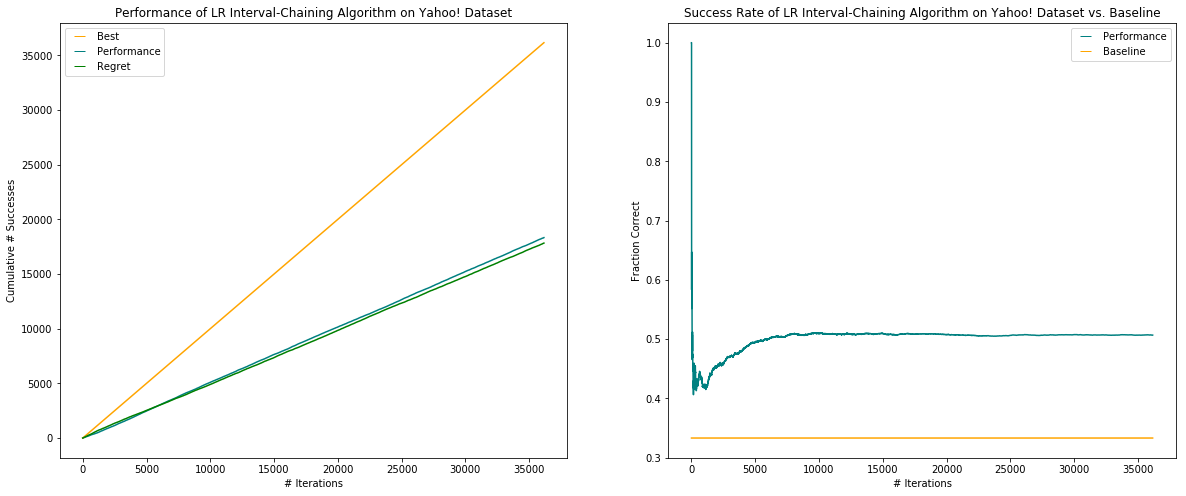

In [177]:
plot_performance(performance_run_2, titles=[
    'Performance of LR Interval-Chaining Algorithm on Yahoo! Dataset',
    'Success Rate of LR Interval-Chaining Algorithm on Yahoo! Dataset vs. Baseline'
])

## Examining Malformed Data

I observed that some of the event log items have > 20 articles in the article pool, which creates a problem since we assume a constant $k$ arms across all events.

It turns out that there are around 2.53 million such events out of the 4.68 million in the first batch file, which is a lot! 

Additionally, it is worth noting that there are a good number of articles that have identical feature vectors despite having different labels.

However, it is not as simple as removing the duplicates for all logged event items, as I determined at least one such case where doing so would result in < 20 articles in the pool. Therefore, distinct articles are distinct despite having identical article vectors (which is troublesome). 

A workaround I am using now is simply to only select the events with 20 articles, which seems to work in the interim.

In [ ]:
pd.read_sql_query('''SELECT COUNT(*) FROM clicks''', con=engine)

In [ ]:
pd.read_sql_query('''SELECT COUNT(*) FROM clicks''', con=engine)
bad_df = pd.read_sql_query('''SELECT * FROM clicks WHERE length(article_pool) >= 210''', con=engine)
len(bad_df)

In [ ]:
bad_sample = eval(bad_df.ix[80840]['article_pool'])

In [ ]:
dupes = pd.DataFrame(articles_df.duplicated(), columns=['Result'])
articles_df.ix[list(dupes[dupes.Result == True].index)]

In [ ]:
# I've constructed an inverse index to allow swift de-duplication of articles with identical vectors.
d1 = {key:'109509' for key in ['109509', '109503', '109494', '109525', '109530', '109533', '109545']}
d2 = {key:'109506' for key in ['109506', '109547', '109550']}
d3 = {key:'109527' for key in ['109527', '109531', '109543']}
dupe_index = {**d1, **d2, **d3}

In [ ]:
print(len(bad_sample))
print(len(set(map(lambda x : dupe_index[x] if x in dupe_index else x, bad_sample))))

In [ ]:
dupe_index['109509']

The assumption of maintaining 20 different arms proved to be a poor choice. Instead, I run a clustering algorithm to clump together the articles.

In [ ]:
num_clusters = 4
model = KMeans(n_clusters=num_clusters)
predictions = model.fit_predict(articles_df.dropna().as_matrix())
clusters = dict(zip(list(articles_df.dropna().index), predictions))
clicks_df['reduced'] = clicks_df['article_pool'].apply(lambda x : list(set([clusters[y] for y in x])))
clicks_df['displayed_reduced'] = clicks_df['displayed'].apply(lambda x : clusters[str(x)])